<a href="https://colab.research.google.com/github/ABoldetti/My_first_Repository/blob/main/python/Labo2/Micronde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title checkbox

UPDATE_DATA = False # @param {type:"boolean"}
show = False # @param {type:"boolean"}




# Utilities

In [ ]:
#@title Librerie

try:
  from iminuit import Minuit
  from iminuit.cost import *
except:
  !pip install iminuit
  from iminuit import Minuit
  from iminuit.cost import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
from scipy.stats import chi2,skew,kurtosis,norm
from IPython.display import Latex


In [ ]:
#@title import file

try:
  if UPDATE_DATA:
    print(SHEEESH)
  else:
    ausy = data[0]
except:
  data = 'https://docs.google.com/spreadsheets/d/18VyvHT-tabSLBXbUxMP-o8AFPnOkWPFnSLe0k9nD7sg/export?format=xlsx'
  df = pd.read_excel(data, sheet_name=None)
  name =list(df.keys())
  data = []
  for i in range(len(df.keys())):
    data.append(df[name[i]])


In [ ]:
#@title error prop

def insert( vector ) -> list:
    #Handling edge cases
    if len(vector) == 1:
      vector = symbols( str(vector) )
      sigmas = f"sigma_{vector}"
      covar = None
      all = sigmas
    elif len(vector) == 2:
      string = ' '.join( vector )
      vector = symbols( string )
    #creation of sigmas and covariants
      sigmas = []
      covar = []
      all = []
      for i in range(len(vector)):
        sigmas.append( f"sigma_{vector[i]}" )
        all.append( f"sigma_{vector[i]}" )
      sigmastring = ' '.join( sigmas )
      sigmas = symbols( sigmastring )
      covar.append(f"sigma_{vector[0]}{vector[1]}")
      covarstring = ' '.join( covar )
      covar = symbols( covarstring )
      all.append(covar)
    else:
      string = ' '.join( vector )
      vector = symbols( string )
      #creation of sigmas and covariants
      sigmas = []
      covar = []
      all = []
      for i in range(len(vector)):
        for j in range( i , len(vector)):
          if i == j:
            sigmas.append( f"sigma_{vector[i]}" )
            all.append( f"sigma_{vector[i]}" )
          else:
            covar.append( f"sigma_{vector[i]}{vector[j]}")
            all.append( f"sigma_{vector[i]}{vector[j]}")

      sigmastring = ' '.join( sigmas )
      sigmas = symbols( sigmastring )
      covarstring = ' '.join( covar )
      covar = symbols( covarstring )
    return vector, sigmas , covar, all

def derivazione(variables, formula, sigmas , covar) -> str:
    expo = 0
    # add the sigmas
    for i in range(len(variables)):
      expo += (diff(formula, variables[i]))**2 * sigmas[i]
      # add the covs
    k = 0
    if isinstance( covar , Symbol) :
      expo += 2 * (diff(formula, variables[0])) * (diff(formula, variables[1])) * covar
    else:
      for i in range(len(variables)):
        for j in range(len(variables)-i-1):
          expo += 2 * (diff(formula, variables[i])) * (diff(formula, variables[1+j+i])) * covar[k]
          k += 1
    return expo



def propagazione_errore (vector, formula , values , covmat , var_else = None, val_else = None, Display = True) -> str:

    if isinstance(var_else , list):
      things,a,a,a = insert(var_else)

    variables,sigmas,covar,all = insert(vector)

    expo = derivazione (variables, formula, sigmas , covar)

    if Display: display(Latex('\sigma='+latex(simplify(sqrt(expo)))))

    if len(variables) == 1:
      expo = expo.subs( variables , values)
      expo = expo.subs( sigmas , covmat)
    else:
      for i in range(len(variables)): expo = expo.subs( variables[i] , values[i])
      k = 0
      for i in range(len(covmat)):
        expo = expo.subs( all[k] , covmat[i][i])
        k +=1
      for i in range( len(covmat)):
        for j in range(i+1 , len(covmat[i])):
          expo = expo.subs( all[k] , covmat[i][j])
          k+=1
    if isinstance(var_else , list):
      if len(var_else ) == 1:
        expo = expo.subs( symbols(var_else[0]) , val_else[0])
      else:
        for i in range(len(var_else)): expo = expo.subs( things[i] , val_else[i])
    return sqrt(expo)


# Modelli

In [ ]:
#Costanti

alfa = 0.3
l = .03

#Utils
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def gauss_pdf( x , scale , mean , sigma):
  return scale*norm.pdf( x , loc = mean , scale = sigma)

def gauss_cdf( x , scale , mean , sigma):
  return scale*norm.cdf( x , loc = mean , scale = sigma)

def parab( r , A , B , C):
  return A * np.power(r , 2) + B * r + C

def pcomp( r , A , B , C, D):
  return D*np.power( A*r + B, 2) + C

def fun( n ):
  c = np.ceil(n)
  if abs(c-n)< .5: return c
  else: return np.floor(n)

#Polarizzazione
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def pol1( t , A ):
  return A*abs(np.cos(np.pi/180*t))

def pol2( t , A ):
  return A*np.power(np.cos(np.pi/180*t) , 2)

def pol3( t , A , B):
  return A*np.power(np.cos(np.pi/180*t) , 2) + B*abs(np.cos(np.pi/180*t))

#Ampiezza
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def Amp( r , A , B , C):
  return A/np.power(r*1e-2 + B, C)
def Amp1( r , s1 , cos , exp, s2):
  return s1/np.power(r*1e-2 , exp) + s2*abs(np.cos( cos / r*1e-2))
def Amp2( r , s1 , cos , exp):
  s2 = .8/np.pi
  return s1/np.power(r*1e-2 + cos , exp) + abs(np.cos( s2*(r*1e-2)))
def cos( r , a , b , c ):
  return a* np.cos( c*(r + b))

#Geometria
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def geo( t , A , B , C ):
  return abs( A / (np.power(abs( 2*np.pi/180 * t ) , C) + B ))

def geo1( t , A , B , C ):
  return A / ( np.power( np.cos( 2*np.pi/180 * t * C), 2) + B)

def geo2( t , A , B , C ):
  return A / np.power( 1 - np.power( B  *np.pi/360* t , 2 ) , C)

def poli( t , A , B , C , D , E , F):
  return A / np.polyval( [B , C , D , E , F] , abs(np.pi/180*t))

def Tcos( t , A , B , F):
  return A / np.polyval( [B , 0 , 2*B*F , 0 , F] , abs(np.pi/180*t))

#Fabry-Perot
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def fp ( d , l ):
  return 2*d/l


def fabry_perot( d , R , a , b , c):
  return a/( 1 + 4*( R/np.power(1-R , 2)) * np.power( np.sin(b*d/2) , 2) + c)



#Doppia fenditura
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def fenditure( theta , d , Lambda):
  return d/Lambda*np.sin(theta)

# Angolo di Bragg
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def Bragg( theta , d ,Lambda):
  return d/Lambda* np.sin(theta)


# **Presa dati**

-0.0 1.0 0.044 -0.716


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.72 (χ²/ndof = 1.8)      │              Nfcn = 55               │
│ EDM = 0.0873 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ scale │  1.409e3  │  0.014e3  │            │            │         │         │  yes  │
│ 1 │ mean  │  -0.000   │   0.031   │            │            │         │         │       │
│ 2 │ sigma │   1.060   │   0.025   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │    scale     mean    sigma │
├───────┼────────────────────────────┤
│ scale │        0     0e-3        0 │
│  mean │     0e-3  0.00096       -0 │
│ sigma │        0       -0 0.000635 │
└───────┴────────────────────────────┘

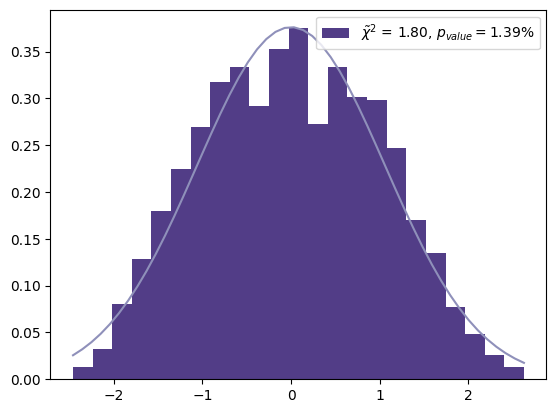

In [ ]:
#@title data dist


n=19
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for ii in range( len(ausy)):
      net.append( (ausy[ii] - avg)/(std))
      continue
    ausy = [ydist[i]]

count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3 * np.log(len(net)))) , density = True , label=chi_string , color = '#523d87')
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]) , color = '#8f90ba')
plt.legend()

print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
display(u)
plt.savefig('hist.pdf')

# Caratterizzazione dell'onda

## Polarizzazione

In [ ]:
#@title analisi dati


n=0
x1 = np.array(data[n][data[n].columns[0]])
y1 = np.array(data[n][data[n].columns[1]])
sy1 = np.array(data[n][data[n].columns[2]])*15



p1 = LeastSquares(x1,y1,sy1 , pol1)
onda11 = Minuit( p1 , A = 2.7448 )

onda11.migrad()
onda11.hesse()

display(onda11)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.37 (χ²/ndof = 1.5)      │              Nfcn = 18               │
│ EDM = 1.86e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   2.745   │   0.010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        A │
├───┼──────────┤
│ A │ 0.000103 │
└───┴──────────┘

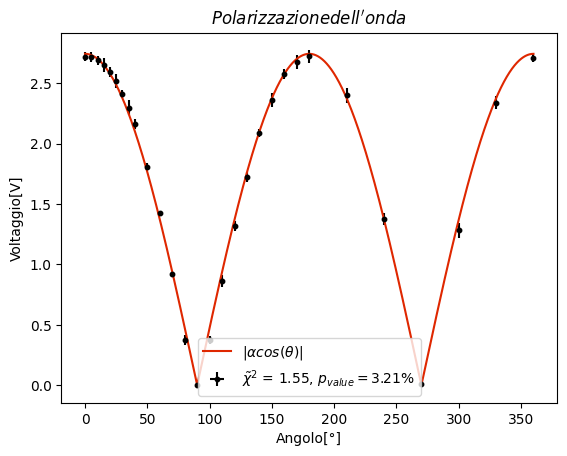

In [ ]:
#@title Graph
a = onda11
x = x1
y = y1
sy = sy1
txt = 'Pol.pdf'
f = pol1


func = r'$|\alpha cos( \theta)|$'
plt.xlabel( 'Angolo[°]')
plt.ylabel( 'Voltaggio[V]')
plt.title('$Polarizzazione dell\'onda$')



chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , xerr= np.ones(len(x)), fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title residui
res = []
for i in range( len(x1)):
  res.append( (y1[i] - pol1(x1[i] , onda11.values[0]))/sy1[i])
  if abs(res[-1] ) > 1000: print( i , '\t' , round(x1[i],3) , round(y1[i],3) , round(sy1[i],3) , '\t' , round(abs(res[-1]),3))
#plt.scatter( x1 , res)
plt.hist(res , bins=int(np.ceil( 1 + 3.322 * np.log(len(res)))))

plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title analisi dati


n=0
x1 = np.array(data[n][data[n].columns[0]])
y1 = np.array(data[n][data[n].columns[1]])
sy1 = np.array(data[n][data[n].columns[2]])



p2 = LeastSquares(x1,y1,sy1 , pol3)
onda12 = Minuit( p2 , A = 2.7448 , B = 1)

onda12.migrad()
onda12.hesse()

display(onda12)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9756 (χ²/ndof = 361.3)     │              Nfcn = 43               │
│ EDM = 4.24e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.0045  │  0.0034   │            │            │         │         │       │
│ 1 │ B    │  2.7486   │  0.0030   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        A        B │
├───┼───────────────────┤
│ A │ 1.19e-05   -10e-6 │
│ B │   -10e-6 8.76e-06 │
└───┴───────────────────┘

In [ ]:
#@title data dist

n=1
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]


count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

## Ampiezza

### Dataset 1

In [ ]:
#@title analisi dati

n=2
x2 = np.array(data[n][data[n].columns[0]])
y2 = np.array(data[n][data[n].columns[1]])
sy2 = np.array(data[n][data[n].columns[2]])*10




Am = LeastSquares(x2,y2,sy2 , Amp)
onda21 = Minuit( Am , A =  61.2, B = .505 , C = 4.22)

onda21.fixed['B'] = True

onda21.migrad()
onda21.hesse()

display(onda21)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 127.3 (χ²/ndof = 8.5)      │              Nfcn = 123              │
│ EDM = 1.54e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.259   │   0.014   │            │            │         │         │       │
│ 1 │ B    │   0.505   │   0.005   │            │            │         │         │  yes  │
│ 2 │ C    │   1.030   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        C │
├───┼────────────────────────────┤
│ A │ 0.000187        0 -0.21e-3 │
│ B │        0        0        0 │
│ C │ -0.21e-3        0 0.000269 │
└───┴────────────────────────────┘

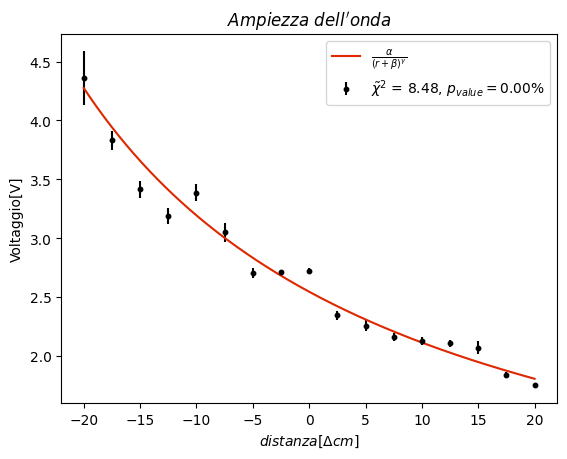

In [ ]:
#@title Graph
a = onda21
x = x2
y = y2
sy = sy2
txt = 'Amp.pdf'
f = Amp

func = r'$ \frac{ \alpha }{ (r + \beta)^{ \gamma} }$'
plt.xlabel( '$distanza[ \Delta cm]$')
plt.ylabel( 'Voltaggio[V]')
plt.title('$ Ampiezza\ dell\'onda $')



chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] , a.values[1] , a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title data dist


n=3
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]

count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

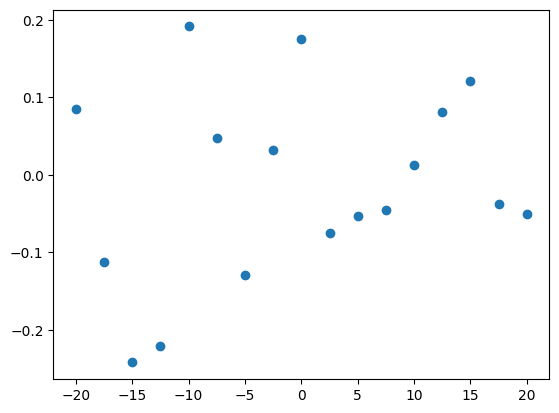

In [ ]:
#@title residui
res = []
for i in range( len(x2)):
  res.append( (y2[i] - Amp(x2[i] , onda21.values[0], onda21.values[1] , onda21.values[2])))
plt.scatter( x2 , res)
#plt.hist(res)

In [ ]:
#@title sine interpolation
xtry = x2[4::]
restry = res[4::]
sytry = sy2[4::]
Am = LeastSquares(xtry,restry,sytry , cos)

onda22 = Minuit( Am , a= 0.2 , b = 1.3 , c = np.pi/5)


onda22.limits[ 'a' , 'c'] = (0.1,None)
#onda22.fixed['c','b', 'a'] = True
onda22.migrad()
onda22.hesse()

display(onda22)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 59.84 (χ²/ndof = 6.0)      │              Nfcn = 144              │
│ EDM = 4.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.100   │   0.008   │            │            │   0.1   │         │       │
│ 1 │ b    │   0.82    │   0.17    │            │            │         │         │       │
│ 2 │ c    │   0.806   │   0.010   │            │            │   0.1   │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 3.95e-10  -0.1e-9        0 │
│ b │  -0.1e-9   0.0272 -0.98e-3 │
│ c │        0 -0.98e-3 9.02e-05 │
└───┴────────────────────────────┘

### Dataset 2

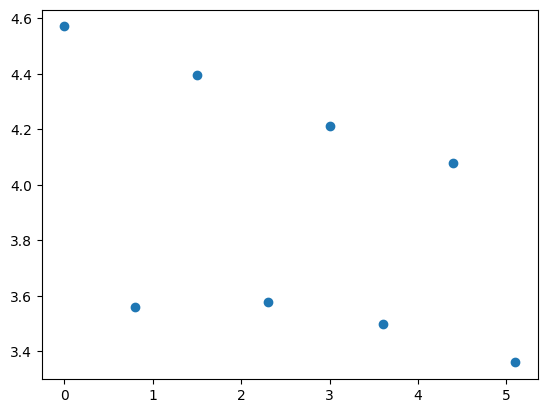

In [ ]:
#@title divisione dati

n=18
x17 = np.array(data[n][data[n].columns[0]])
y17 = np.array(data[n][data[n].columns[1]])
sy17 = np.array(data[n][data[n].columns[2]])

xa = []
ya = []
sya = []
xi = []
yi = []
syi = []

for i in range( len(x17) ):
  if i%2 == 0:
    xa.append( x17[i] )
    ya.append( y17[i] )
    sya.append( sy17[i] )
  else:
    xi.append( x17[i] )
    yi.append( y17[i] )
    syi.append( sy17[i] )

syi[0] *=5
plt.scatter( x17 , y17)

In [ ]:
#@title massimi

print(xa)
Af = LeastSquares(xa,ya,sya , Amp)
onda23 = Minuit( Af , A = 1 , B = 1 , C = 1 )

onda23.limits['B'] = (.00001 , None)

onda23.migrad()
onda23.hesse()
display(onda23)

delta = []
for i in range( 1 , len(xa)):
  delta.append( xa[i-1] - xa[i])
print( delta)

[0.0, 1.5, 3.0, 4.4]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.4912 (χ²/ndof = 0.5)     │              Nfcn = 724              │
│ EDM = 0.000431 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.68    │   0.15    │            │            │         │         │       │
│ 1 │ B    │   0.42    │   0.16    │            │            │  1e-05  │         │       │
│ 2 │ C    │    1.1    │    0.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────┐
│   │      A      B      C │
├───┼──────────────────────┤
│ A │ 0.0235  0.020  0.047 │
│ B │  0.020  0.025  0.065 │
│ C │  0.047  0.065  0.171 │
└───┴──────────────────────┘

[-1.5, -1.5, -1.4000000000000004]


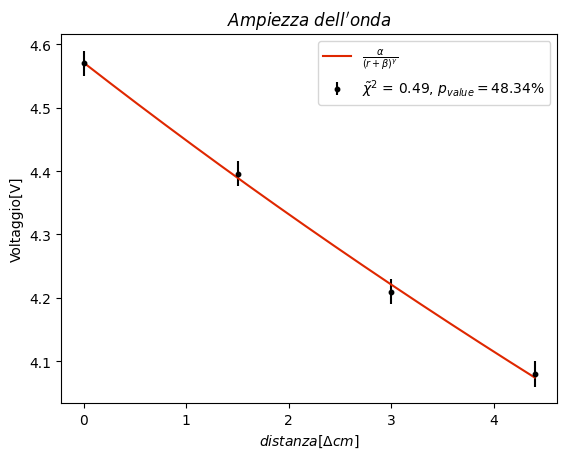

In [ ]:
#@title Graph
a = onda23
x = xa
y = ya
sy = sya
txt = 'Amp_max.pdf'
f = Amp


func = r'$ \frac{ \alpha }{ (r + \beta)^{ \gamma} }$'
plt.xlabel( '$distanza[ \Delta cm]$')
plt.ylabel( 'Voltaggio[V]')
plt.title('$ Ampiezza\ dell\'onda $')



chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] , a.values[1] , a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title minimi

Af = LeastSquares(xi,yi,syi , Amp)
onda24 = Minuit( Af , A = 1 , B = 1 , C = 1 )

onda24.limits['B'] = (.00001 , None)
onda24.fixed['C'] = True

onda24.migrad()
onda24.hesse()
display(onda24)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.36 (χ²/ndof = 1.7)       │              Nfcn = 115              │
│ EDM = 2.59e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.65    │   0.22    │            │            │         │         │       │
│ 1 │ B    │   0.44    │   0.06    │            │            │  1e-05  │         │       │
│ 2 │ C    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       A       B       C │
├───┼─────────────────────────┤
│ A │  0.0466   0.013    0.00 │
│ B │   0.013 0.00384   0.000 │
│ C │    0.00   0.000       0 │
└───┴─────────────────────────┘

## Geometria

In [ ]:
#@title analisi dati

n=4
x3 = np.array(data[n][data[n].columns[0]] , np.float64)
y3 = np.array(data[n][data[n].columns[1]])
sy3 = np.array(data[n][data[n].columns[2]])*10

xm = []
ym = []
sm = []
xp = []
yp = []
sp = []
for i in range(len(x3)):
  if x3[i] < 0 :
    xm.append( x3[i] )
    ym.append( y3[i] )
    sm.append( sy3[i])
  else :
    xp.append( x3[i] )
    yp.append( y3[i] )
    sp.append( sy3[i] )



Geo = LeastSquares(xm,ym,sm , geo)
onda31 = Minuit( Geo , A = 1 , B = 1 , C = 4)

onda31.fixed['C'] = True
onda31.limits['C' , 'B'] = (0.1 , None)

onda31.migrad()
onda31.hesse()

display(onda31)

Geo = LeastSquares(xp,yp,sp , geo)
onda32 = Minuit( Geo , onda31.values[0] , onda31.values[1] , 4 )

onda32.fixed['C'] = True
onda32.limits['C' , 'B'] = (0.1 , None)


onda32.migrad()
onda32.hesse()

display(onda32)




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.527 (χ²/ndof = 2.2)      │              Nfcn = 93               │
│ EDM = 9.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.36    │   0.07    │            │            │         │         │       │
│ 1 │ B    │   0.442   │   0.023   │            │            │   0.1   │         │       │
│ 2 │ C    │   4.00    │   0.04    │            │            │   0.1   │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        C │
├───┼────────────────────────────┤
│ A │  0.00433   1.5e-3    0.000 │
│ B │   1.5e-3 0.000522        0 │
│ C │    0.000        0        0 │
└───┴────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.259 (χ²/ndof = 0.8)      │              Nfcn = 50               │
│ EDM = 3.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.121   │   0.033   │            │            │         │         │       │
│ 1 │ B    │   0.361   │   0.014   │            │            │   0.1   │         │       │
│ 2 │ C    │   4.00    │   0.04    │            │            │   0.1   │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        C │
├───┼────────────────────────────┤
│ A │   0.0011  0.45e-3   0.0000 │
│ B │  0.45e-3 0.000204        0 │
│ C │   0.0000        0        0 │
└───┴────────────────────────────┘

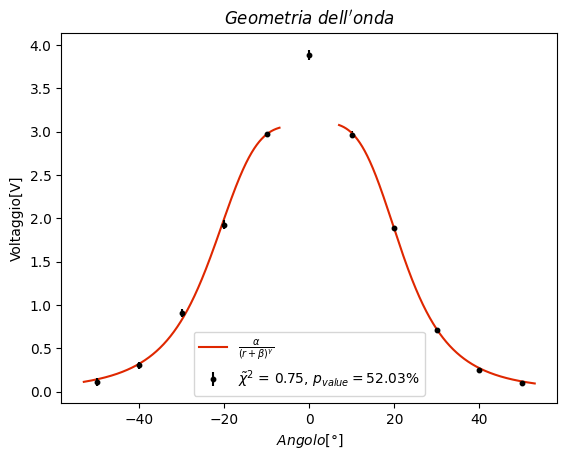

In [ ]:
#@title Graph

n=20
x19 = np.array(data[n][data[n].columns[0]] , np.float64)
y19 = np.array(data[n][data[n].columns[1]])
sy19 = np.array(data[n][data[n].columns[2]])*10



a = onda31
x = xm
y = ym
sy = sm
txt = 'Geometria.pdf'
f = geo


func = r'$ \frac{ \alpha }{ (r + \beta)^{ \gamma} }$'
plt.xlabel( '$Angolo[°]$')
plt.ylabel( 'Voltaggio[V]')
plt.title('$ Geometria\ dell\'onda $')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.plot( np.linspace( min(x)-3 , max(x)+3, 10000) ,f( np.linspace( min(x)-3 , max(x)+3, 10000) , a.values[0] , a.values[1] , a.values[2]), color = '#DF2700')


a = onda32
x = xp
y = yp
sy = sp
f = geo


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x19 , y19 , sy19 , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x)-3 , max(x)+3, 10000) ,f( np.linspace( min(x)-3 , max(x)+3, 10000) , a.values[0] , a.values[1] , a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title prova ellisse

Geo = LeastSquares(xm,ym,sm , Tcos)
onda31 = Minuit( Geo , A = 1.12 , B=	12.7 , F = 0.361)

#onda31.fixed['A'] = True
#onda31.fixed['F'] = True


onda31.migrad()
onda31.hesse()

display(onda31)

Geo = LeastSquares(xp,yp,sp , Tcos)
onda32 = Minuit( Geo , A = 	0.06e-3 , B=	0.001 , F = 0.02e-3)

#onda32.fixed['A'] = True
#onda31.fixed['F'] = True

onda32.migrad()
onda32.hesse()

display(onda32)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.433 (χ²/ndof = 2.2)      │              Nfcn = 328              │
│ EDM = 7.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.07    │   0.05    │            │            │         │         │       │
│ 1 │ B    │    0.7    │    0.5    │            │            │         │         │       │
│ 2 │ F    │   0.021   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        F │
├───┼────────────────────────────┤
│ A │  0.00275   0.0236  0.84e-3 │
│ B │   0.0236    0.203  7.19e-3 │
│ F │  0.84e-3  7.19e-3 0.000256 │
└───┴────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.267 (χ²/ndof = 1.1)      │              Nfcn = 74               │
│ EDM = 0.00116 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  0.1e-3   │  0.6e-3   │            │            │         │         │       │
│ 1 │ B    │   0.001   │   0.008   │            │            │         │         │       │
│ 2 │ F    │  0.02e-3  │  0.19e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        F │
├───┼────────────────────────────┤
│ A │ 3.33e-07  4.75e-6 0.107e-6 │
│ B │  4.75e-6 6.78e-05 1.529e-6 │
│ F │ 0.107e-6 1.529e-6 3.45e-08 │
└───┴────────────────────────────┘

In [ ]:
#@title data dist


n=5
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]

count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

# Brosted

## Dataset 1

In [ ]:
#@title Interpolazione

n=6
x4 = np.array(data[n][data[n].columns[0]] , np.float64)
y4 = np.array(data[n][data[n].columns[1]])
sy4 = np.array(data[n][data[n].columns[2]])

x4 = x4[6::]
y4 = y4[6::]
sy4 = sy4[6::]


angolo = LeastSquares(x4 , y4 , sy4 , parab)
aB = Minuit( angolo , A = 1 , B = 1 , C = 1)

aB.migrad()
aB.hesse()

display(aB)
print( -aB.values[1]/(2*aB.values[0]))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.158 (χ²/ndof = 0.7)      │              Nfcn = 106              │
│ EDM = 1.4e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ -7.875e-3 │ 0.011e-3  │            │            │         │         │       │
│ 1 │ B    │ 666.6e-3  │  0.6e-3   │            │            │         │         │       │
│ 2 │ C    │  -11.562  │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         A         B         C │
├───┼───────────────────────────────┤
│ A │  1.17e-10  -3.93e-9 -50.88e-9 │
│ B │  -3.93e-9  3.41e-07  -7.36e-6 │
│ C │ -50.88e-9  -7.36e-6  0.000417 │
└───┴───────────────────────────────┘

42.320564105428446


In [ ]:
#@title data dist

n=7
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])


ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]


count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

## Dataset 2

In [ ]:
#@title Interpolazione

n=8
x5 = np.array(data[n][data[n].columns[0]] , np.float64)
y5 = np.array(data[n][data[n].columns[1]])
sy5 = np.array(data[n][data[n].columns[2]])


#x5 = x5[6::]
#y5 = y5[6::]
#sy5 = sy5[6::]
#x4 = x4[6::]

angolo = LeastSquares(x5 , y5 , sy5 , parab)
aB = Minuit( angolo , A = 1 , B = 1 , C = 1)

aB.migrad()
aB.hesse()

display(aB)

print( -aB.values[1]/(2*aB.values[0]))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.12 (χ²/ndof = 5.4)      │              Nfcn = 111              │
│ EDM = 1.79e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ -2.78e-3  │  0.24e-3  │            │            │         │         │       │
│ 1 │ B    │   0.128   │   0.010   │            │            │         │         │       │
│ 2 │ C    │   1.10    │   0.11    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        A        B        C │
├───┼────────────────────────────┤
│ A │ 5.67e-08 -2.47e-6 26.53e-6 │
│ B │ -2.47e-6 0.000108 -1.16e-3 │
│ C │ 26.53e-6 -1.16e-3   0.0126 │
└───┴────────────────────────────┘

22.96509928363651


In [ ]:
#@title data dist


n=9
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]

count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

# Fabry Perot

## Dataset 1
----------------------Non so cosa farci------------------------

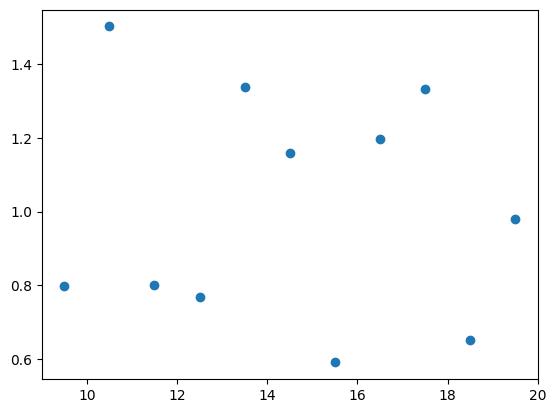

In [ ]:
#@title analisi dati


n=10
x6 = np.array(data[n][data[n].columns[0]] , np.float64)
y6 = np.array(data[n][data[n].columns[1]])
sy6 = np.array(data[n][data[n].columns[2]])

plt.scatter( x6 , y6)


In [ ]:
#@title data dist


n=11
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]


count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

## Dataset 2

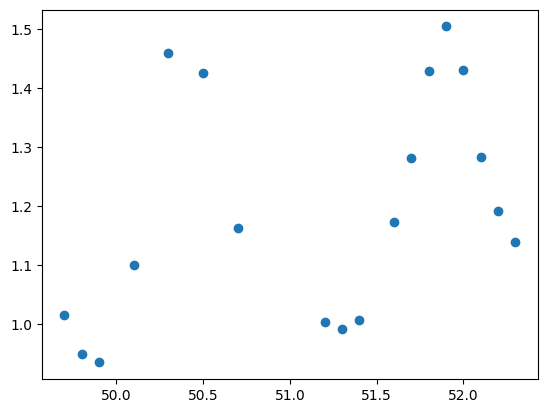

In [ ]:
#@title analisi dati

soglia = [4 , 7 , 11]

n=12
x7 = np.array(data[n][data[n].columns[0]] , np.float64)
y7 = np.array(data[n][data[n].columns[1]])
sy7 = np.array(data[n][data[n].columns[2]])

#print( data[12] )

plt.scatter( x7 , y7 )

min1 = { "x": x7[:soglia[0]:] , "y": y7[:soglia[0]:] , "sy": sy7[:soglia[0]:]}
max1 = { "x": x7[soglia[0]-1:soglia[1]:] , "y": y7[soglia[0]-1:soglia[1]:], "sy": sy7[soglia[0]-1:soglia[1]:]}
min2 = { "x": x7[soglia[1]:soglia[2]:] , "y": y7[soglia[1]:soglia[2]:], "sy": sy7[soglia[1]:soglia[2]:]}
max2 = { "x": x7[soglia[-1]::] , "y": y7[soglia[-1]::] , "sy": sy7[soglia[-1]::]}



In [ ]:
#@title interpolazione

x72 = x7 - 51
p = LeastSquares( x72 , y7 , sy7 , fabry_perot)
fabp = Minuit( p , R = 10 , a = 3 , b = np.pi/0.5 , c = np.pi)

fabp.limits['R' , 'a'] = (.000000001 , None)
fabp.fixed['b'] = True

fabp.migrad()
fabp.hesse()

display( fabp )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.772e+04 (χ²/ndof = 1181.6)│              Nfcn = 139              │
│ EDM = 8.73e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │    21     │     4     │            │            │  1e-09  │         │       │
│ 1 │ a    │    2.9    │    0.7    │            │            │  1e-09  │         │       │
│ 2 │ b    │   6.28    │   0.06    │            │            │         │         │  yes  │
│ 3 │ c    │    1.4    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │     R     a     b     c │
├───┼─────────────────────────┤
│ R │  19.5  -2.9     0 -2.40 │
│ a │  -2.9 0.439   0.0  0.37 │
│ b │     0   0.0     0  0.00 │
│ c │ -2.40  0.37  0.00 0.306 │
└───┴─────────────────────────┘

In [ ]:
#@title data dist


n=13
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]


count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

### Parab distanza

In [ ]:
#@title min1

a = min1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m1 = Minuit( p , A = 1.7521 , B = -87.37 , C = 0.9327, D = 1)

#m1.fixed['B'] = True
m1.fixed['D'] = True

m1.migrad()
m1.hesse()

display( m1)

print( -m1.values[1]/m1.values[0])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.4062 (χ²/ndof = 0.4)     │              Nfcn = 64               │
│ EDM = 4.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  1.7521   │  0.0015   │            │            │         │         │       │
│ 1 │ B    │  -87.37   │   0.07    │            │            │         │         │       │
│ 2 │ C    │  0.9327   │  0.0029   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  2.22e-06 -110.8e-6   -0.2e-6         0 │
│ B │ -110.8e-6   0.00555      3e-6     0.000 │
│ C │   -0.2e-6      3e-6  8.24e-06      0e-6 │
│ D │         0     0.000      0e-6         0 │
└───┴─────────────────────────────────────────┘

49.86584508479969


In [ ]:
#@title max1

a = max1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m2 = Minuit( p , A = 1.993 , B = -100.47 , C = 1.488 , D = -1)

m2.limits['D']= ( None , 0)
m2.fixed['D'] = True

m2.migrad()
m2.hesse()

display( m2 )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.15 (χ²/ndof = 20.1)     │              Nfcn = 65               │
│ EDM = 4.64e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.993   │   0.004   │            │            │         │         │       │
│ 1 │ B    │  -100.47  │   0.20    │            │            │         │         │       │
│ 2 │ C    │   1.488   │   0.004   │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │    0    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  1.55e-05 -0.781e-3  0.004e-3         0 │
│ B │ -0.781e-3    0.0393 -0.191e-3      0.00 │
│ C │  0.004e-3 -0.191e-3  1.42e-05         0 │
│ D │         0      0.00         0         0 │
└───┴─────────────────────────────────────────┘

In [ ]:
#@title min2

a = min2
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m3 = Minuit( p , A = 1.993 , B = -100.47 , C = 1.488 , D = 1.)

#m3.limits['D']= ( None , 0)
m3.fixed['D'] = True

m3.migrad()
m3.hesse()

display( m3 )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.09 (χ²/ndof = 1.1)       │              Nfcn = 209              │
│ EDM = 3.2e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  1.4361   │  0.0015   │            │            │         │         │       │
│ 1 │ B    │  -73.67   │   0.08    │            │            │         │         │       │
│ 2 │ C    │  0.9863   │  0.0033   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  2.19e-06 -112.2e-6   -0.2e-6         0 │
│ B │ -112.2e-6   0.00581 -0.009e-3     0.000 │
│ C │   -0.2e-6 -0.009e-3  1.07e-05         0 │
│ D │         0     0.000         0         0 │
└───┴─────────────────────────────────────────┘

In [ ]:
#@title max2

a = max2
x = a['x']
y = a['y']
sy = a['sy']

x = x[:-1:]
y = y[:-1:]
sy = sy[:-1:]


p = LeastSquares( x , y , sy , pcomp)
m4 = Minuit( p , A = 1.847 , B = -95.9 , C = 1.4731 , D = -1)



#m4.limits['D']= ( None , 0)
m4.fixed['D'] = True

m4.migrad()
m4.hesse()

display( m4 )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.65 (χ²/ndof = 25.6)     │              Nfcn = 112              │
│ EDM = 2.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   2.005   │   0.007   │            │            │         │         │       │
│ 1 │ B    │  -104.1   │    0.4    │            │            │         │         │       │
│ 2 │ C    │  1.4879   │  0.0027   │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        A        B        C        D │
├───┼─────────────────────────────────────┤
│ A │ 4.65e-05 -2.42e-3     6e-6        0 │
│ B │ -2.42e-3    0.126  -337e-6     0.00 │
│ C │     6e-6  -337e-6 7.27e-06     0e-6 │
│ D │        0     0.00     0e-6        0 │
└───┴─────────────────────────────────────┘

### Distanza

[0.01371607 0.02461878 0.04237264 0.05486428]
--------------------------------------------------------------------------
[0.9144047441941182, 1.6412519400320056, 2.8248425094742964, 3.657618976776473]
[[1.0, 0.08559525580588179], [2.0, 0.3587480599679944], [3.0, 0.17515749052570362], [4.0, 0.34238102322352715]]
--------------------------------------------------------------------------


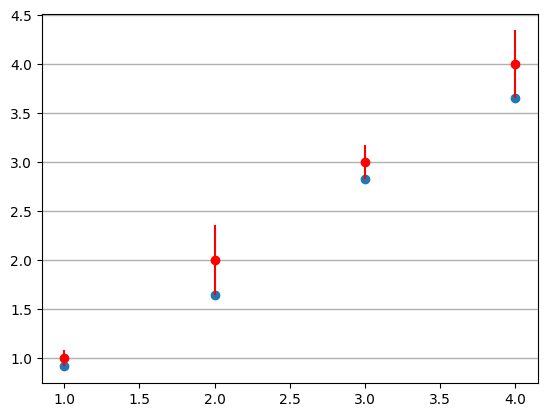

In [ ]:
m = [m1,m2,m3,m4]
max_c = []
err = []



for i in m:
  max_c.append( i.values[1]/i.values[0]*-1e-2)
  err.append( propagazione_errore( ['A' , 'B' , 'C' , 'D'] , '-B/A' , i.values , i.covariance, Display = False )*1e-2)

dist1 = np.array([ max_c[i] - max_c[i-1]                                                                               for i in range( 1 , len(max_c))])
dist_err = np.array([ 1/(np.sqrt(2))*np.sqrt( np.power(float(err[i]),2) + np.power(float(err[i-1]),2))                           for i in range( 1 , len(max_c))])

max_b = 2*(np.array(max_c) - min(max_c) + np.mean(dist1))
print( max_b)
print('--------------------------------------------------------------------------')
n1 = [ fp(j ,  l) for j in max_b]
print(n1)


arr1 = [ [fun(i) , abs(fun(i)-i)] for i in n1]
print( arr1 )
print('--------------------------------------------------------------------------')
plt.grid(visible= True , which='major' , axis = 'y' , linewidth = 1)
plt.errorbar( [1 , 2 , 3 , 4] , [fun(i) for i in n1] , [abs(fun(i)-i)  for i in n1] , fmt = 'o', color = 'red')
plt.scatter( [1 , 2 , 3 , 4] , n1)
plt.show()

### Parab grafico

In [ ]:
def fab( x ):
  x71 = 2*(np.array(x*1e-2) - min(max_c) + np.mean(dist1))
  return fp(x71 ,  l)

min1 = { "x": fab(x7[:soglia[0]:]) , "y": y7[:soglia[0]:] , "sy": sy7[:soglia[0]:]}
max1 = { "x": fab(x7[soglia[0]-1:soglia[1]:]) , "y": y7[soglia[0]-1:soglia[1]:], "sy": sy7[soglia[0]-1:soglia[1]:]}
min2 = { "x": fab(x7[soglia[1]:soglia[2]:]) , "y": y7[soglia[1]:soglia[2]:], "sy": sy7[soglia[1]:soglia[2]:]}
max2 = { "x": fab(x7[soglia[-1]::]) , "y": y7[soglia[-1]::] , "sy": sy7[soglia[-1]::]}

In [ ]:
#@title min1



a = min1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m11 = Minuit( p , A = 1 , B = 1 , C = 1, D = 1)

#m11.fixed['B'] = True
m11.fixed['D'] = True

m11.migrad()
m11.hesse()

display( m11)

print( -m1.values[1]/m1.values[0])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.4063 (χ²/ndof = 0.4)     │              Nfcn = 321              │
│ EDM = 2.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.314   │   0.034   │            │            │         │         │       │
│ 1 │ B    │   -1.20   │   0.04    │            │            │         │         │       │
│ 2 │ C    │   0.933   │   0.004   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │   0.00113   -0.0012 -0.082e-3    0.0000 │
│ B │   -0.0012   0.00134  0.082e-3    0.0000 │
│ C │ -0.082e-3  0.082e-3  1.42e-05         0 │
│ D │    0.0000    0.0000         0         0 │
└───┴─────────────────────────────────────────┘

49.86584508479969


In [ ]:
#@title max1

a = max1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m12 = Minuit( p , A = 1 , B = 1, C = 1 , D = -1)

m12.limits['D']= ( None , 0)
m12.fixed['D'] = True

m12.migrad()
m12.hesse()

display( m12 )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.15 (χ²/ndof = 20.1)     │              Nfcn = 311              │
│ EDM = 3.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -1.495   │   0.017   │            │            │         │         │       │
│ 1 │ B    │   2.453   │   0.027   │            │            │         │         │       │
│ 2 │ C    │   1.488   │   0.007   │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │    0    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        A        B        C        D │
├───┼─────────────────────────────────────┤
│ A │ 0.000294 -0.46e-3 -0.09e-3        0 │
│ B │ -0.46e-3 0.000726  0.15e-3        0 │
│ C │ -0.09e-3  0.15e-3 4.35e-05        0 │
│ D │        0        0        0        0 │
└───┴─────────────────────────────────────┘

In [ ]:
#@title min2

a = min2
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
m13 = Minuit( p , A = 1, B = 1 , C = 1, D = 1.)

#m13.limits['D']= ( None , 0)
m13.fixed['D'] = True

m13.migrad()
m13.hesse()

display( m13 )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.09 (χ²/ndof = 1.1)       │              Nfcn = 378              │
│ EDM = 2.6e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.08    │   0.04    │            │            │         │         │       │
│ 1 │ B    │   -3.04   │   0.12    │            │            │         │         │       │
│ 2 │ C    │  0.9863   │  0.0033   │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │   0.00139   -0.0044  0.011e-3    0.0000 │
│ B │   -0.0044    0.0138 -0.052e-3     0.000 │
│ C │  0.011e-3 -0.052e-3  1.08e-05         0 │
│ D │    0.0000     0.000         0         0 │
└───┴─────────────────────────────────────────┘

In [ ]:
#@title max2

a = max2
x = a['x']
y = a['y']
sy = a['sy']

x = x[:-1:]
y = y[:-1:]
sy = sy[:-1:]


p = LeastSquares( x , y , sy , pcomp)
m14 = Minuit( p , A = 1, B = 1 , C = 1 , D = -1)



#m14.limits['D']= ( None , 0)
m14.fixed['D'] = True

m14.migrad()
m14.hesse()

display( m14 )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.65 (χ²/ndof = 25.6)     │              Nfcn = 393              │
│ EDM = 5.54e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   1.504   │   0.017   │            │            │         │         │       │
│ 1 │ B    │   -5.50   │   0.07    │            │            │         │         │       │
│ 2 │ C    │   1.488   │   0.004   │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  0.000304  -1.13e-3  0.056e-3         0 │
│ B │  -1.13e-3   0.00422 -0.210e-3     0.000 │
│ C │  0.056e-3 -0.210e-3  1.68e-05         0 │
│ D │         0     0.000         0         0 │
└───┴─────────────────────────────────────────┘

### Grafico

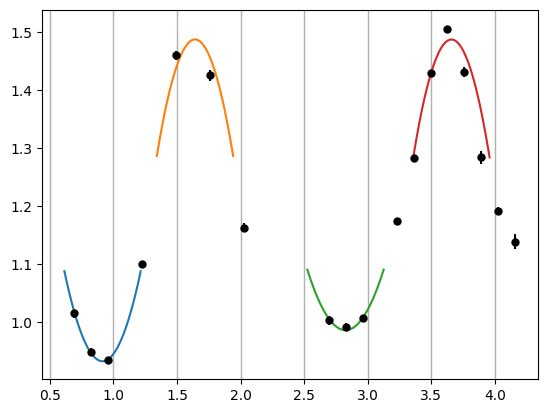

In [ ]:
#@title graph

list_m = [m11 , m12 , m13 , m14]
dict_fp = { "data": [ min1 , max1 , min2 , max2] , "minuit" : list_m}
x71 = fab( x7)

#plt.fill_between( x71 , y7 , 0.9, color = 'plum')
plt.errorbar( x71   , y7 , sy7 , fmt = 'o' , color = '#000000' , markersize = 5)
plt.grid(visible= True , which = 'major' , axis = 'x' , linewidth = 1)

coord = dict_fp['data']
m_fp = dict_fp['minuit']
for i in range(len(list_m)):
  #x = np.linspace( min((coord[i]['x']))+0.1 , max((coord[i]['x']))-0.1 , 1000)
  x = np.linspace( -m_fp[i].values[1]/m_fp[i].values[0] - alfa , -m_fp[i].values[1]/m_fp[i].values[0] + alfa)

  plt.plot( x , pcomp( x , m_fp[i].values[0] , m_fp[i].values[1] , m_fp[i].values[2] , m_fp[i].values[3]))
plt.show()

# Doppia Fenditura

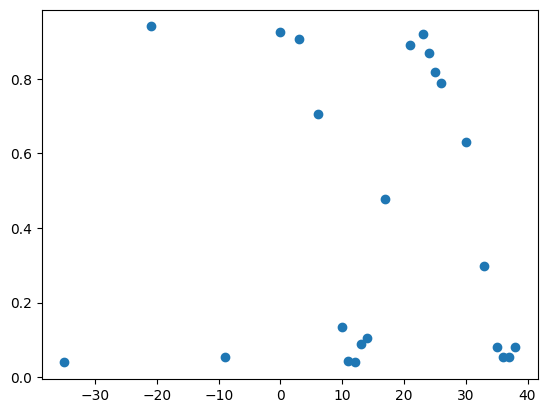

In [ ]:
#@title analisi dati

soglia = [ 3 , 8 , 14]

n=14
x8 = np.array(data[n][data[n].columns[0]] , np.float64)
y8 = np.array(data[n][data[n].columns[1]])
sy8 = np.array(data[n][data[n].columns[2]])

plt.scatter( x8 , y8)

x = x8[:-4:]
y = y8[:-4:]
sy = sy8[:-4:]



nax1 = { "x": x[:soglia[0]:] , "y": y[:soglia[0]:] , "sy": sy[:soglia[0]:]}
nin1 = { "x": x[soglia[0]-1:soglia[1]:] , "y": y[soglia[0]-1:soglia[1]:], "sy": sy[soglia[0]-1:soglia[1]:]}
nax2 = { "x": x[soglia[1]:soglia[2]:] , "y": y[soglia[1]:soglia[2]:], "sy": sy[soglia[1]:soglia[2]:]}
nin2 = { "x": x[soglia[-1]::] , "y": y[soglia[-1]::] , "sy": sy[soglia[-1]::]}


In [ ]:
#@title data dist


n=15
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]


count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>

## Parab

In [ ]:
#@title max1

a = nax1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
o1 = Minuit( p , A = 1.7521 , B = 1 , C = 1, D = -1)

#o1.fixed['B'] = True
o1.fixed['D'] = True

o1.migrad()
o1.hesse()

display( o1 )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.731e-09                  │              Nfcn = 510              │
│ EDM = 4.73e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │ 72.90e-3  │  0.16e-3  │            │            │         │         │       │
│ 1 │ B    │   1.600   │   0.004   │            │            │         │         │       │
│ 2 │ C    │   0.945   │   0.004   │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        A        B        C        D │
├───┼─────────────────────────────────────┤
│ A │ 2.67e-08 0.611e-6 0.553e-6        0 │
│ B │ 0.611e-6 1.47e-05 0.012e-3        0 │
│ C │ 0.553e-6 0.012e-3 1.36e-05        0 │
│ D │        0        0        0        0 │
└───┴─────────────────────────────────────┘

In [ ]:
#@title min1

a = nin1
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
o2 = Minuit( p , A = 1.7521 , B = 1 , C = 1, D = 1)

#o2.fixed['B'] = True
o2.fixed['D'] = True

o2.migrad()
o2.hesse()

display( o2 )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.379e+04 (χ²/ndof = 7930.1)│              Nfcn = 564              │
│ EDM = 1.27 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  2.21e-3  │  0.11e-3  │            │            │         │         │       │
│ 1 │ B    │   1.67    │   0.07    │            │            │         │         │       │
│ 2 │ C    │   -2.59   │   0.24    │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  1.23e-08 -6.571e-6 21.970e-6         0 │
│ B │ -6.571e-6   0.00515    -0.017     0.000 │
│ C │ 21.970e-6    -0.017    0.0575      0.00 │
│ D │         0     0.000      0.00         0 │
└───┴─────────────────────────────────────────┘

In [ ]:
#@title max2

a = nax2
x = a['x']
y = a['y']
sy = a['sy']

p = LeastSquares( x , y , sy , pcomp)
o3 = Minuit( p , A = 1.7521 , B = 1 , C = 1, D = -1)

#o3.fixed['B'] = True
o3.fixed['D'] = True

o3.migrad()
o3.hesse()

display( o3 )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 219.8 (χ²/ndof = 73.3)     │              Nfcn = 571              │
│ EDM = 0.434 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  23.0e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ B    │   -2.35   │   0.05    │            │            │         │         │       │
│ 2 │ C    │   4.25    │   0.24    │            │            │         │         │       │
│ 3 │ D    │   -1.00   │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         A         B         C         D │
├───┼─────────────────────────────────────────┤
│ A │  6.67e-07   32.7e-6 -170.1e-6         0 │
│ B │   32.7e-6   0.00241   -0.0116    0.0000 │
│ C │ -170.1e-6   -0.0116    0.0567      0.00 │
│ D │         0    0.0000      0.00         0 │
└───┴─────────────────────────────────────────┘

In [ ]:
#@title min2

a = nin2
x = a['x']
y = a['y']
sy = a['sy']



p = LeastSquares( x , y , sy , pcomp)
o4 = Minuit( p , A = 1.7521 , B = 1 , C = 1, D = 1)

#o4.fixed['B'] = True
o4.fixed['D'] = True

o4.migrad()
o4.hesse()

display( o4 )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.63 (χ²/ndof = 31.3)     │              Nfcn = 563              │
│ EDM = 0.156 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  23.2e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ B    │  -2.106   │   0.016   │            │            │         │         │       │
│ 2 │ C    │   -1.49   │   0.07    │            │            │         │         │       │
│ 3 │ D    │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        A        B        C        D │
├───┼─────────────────────────────────────┤
│ A │ 2.74e-07  0.88e-6 25.22e-6        0 │
│ B │  0.88e-6 0.000262  0.82e-3        0 │
│ C │ 25.22e-6  0.82e-3  0.00443    0.000 │
│ D │        0        0    0.000        0 │
└───┴─────────────────────────────────────┘

## Distanze





[-1.8683772914436392, -2.8862861246617255, 4.88993586331906, 4.9993734427927015]
[[-2.0, 0.13162270855636082], [-3.0, 0.11371387533827448], [5.0, 0.11006413668093984], [5.0, 0.0006265572072985393]]


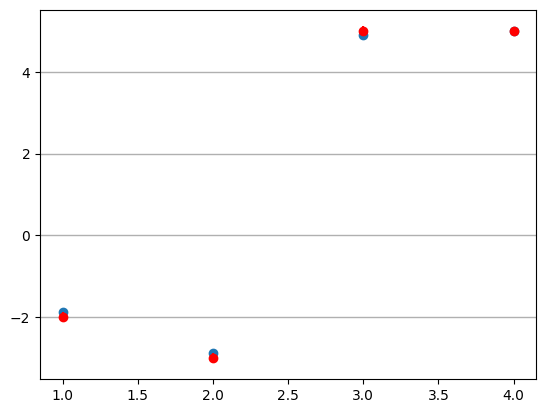

In [ ]:
m = [o1,o2,o3,o4]
max_v = []
err = []


for minuit in m:
  print( )
  max_v.append( -minuit.values[1]/minuit.values[0]*np.pi/180)
  err.append( propagazione_errore( ['A' , 'B' , 'C' , 'D'] , '-B/A' , minuit.values , minuit.covariance, Display = False )*np.pi/180)


dist = 0.15


n2 = [ fenditure(j , dist , l) for j in max_v]
print(n2)

arr2 = [ [fun(i) , abs(fun(i)-i)] for i in n2]
print( arr2 )

plt.grid(visible= True , which='major' , axis = 'y' , linewidth = 1)
plt.errorbar( [1 , 2 , 3 , 4] , [fun(i) for i in n2] , [abs(fun(i)-i)  for i in n2] , fmt = 'o', color = 'red')
plt.scatter( [1 , 2 , 3 , 4] , n2)
plt.show()

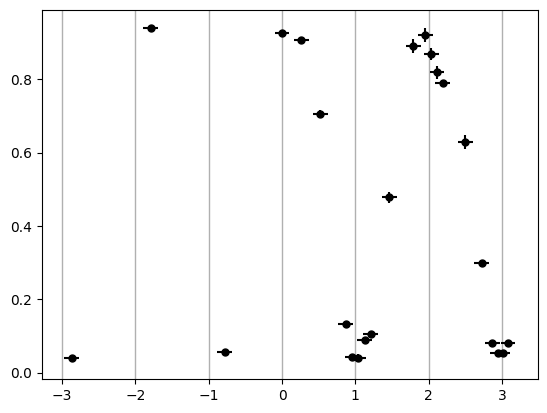

In [ ]:
#@title graph

x81 = fenditure( x8*np.pi/180 , dist , l )


#plt.fill_between( x81 , y8 , 0 , color = 'plum')
plt.errorbar( x81   , y8 , sy8 , xerr=0.1 , fmt = 'o' , color = '#000000' , markersize = 5)
plt.grid(visible= True , which = 'major' , axis = 'x' , linewidth = 1)
#plt.plot( np.linspace( min(x81)-0.3 , max(x81)+0.3 , 1000),  0.455*np.sin((np.linspace( min(x81)-0.3 , max(x81)+0.3 , 1000)+0.45)*np.pi)+ 0.49 , color = '#DF2700')
plt.show()

# Angolo di Bragg

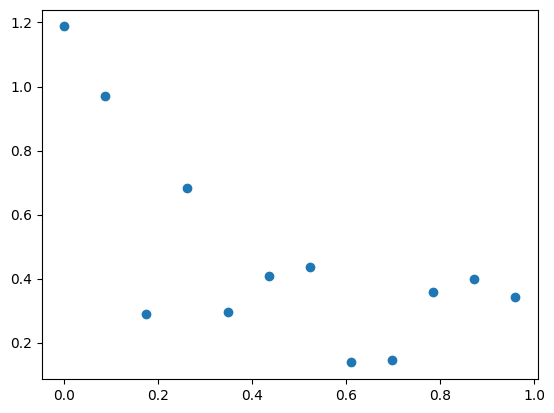

In [ ]:
#@title analisi dati

n=16
x9 = np.array(data[n][data[n].columns[0]] , np.float64)
y9 = np.array(data[n][data[n].columns[1]])
sy9 = np.array(data[n][data[n].columns[2]])

plt.scatter( x9*np.pi/180 , y9)


[2.070552360820166, 3.9999999999999996, 6.128355544951824]
[[2.0, 0.07055236082016592], [4.0, 4.440892098500626e-16], [6.0, 0.1283555449518241]]


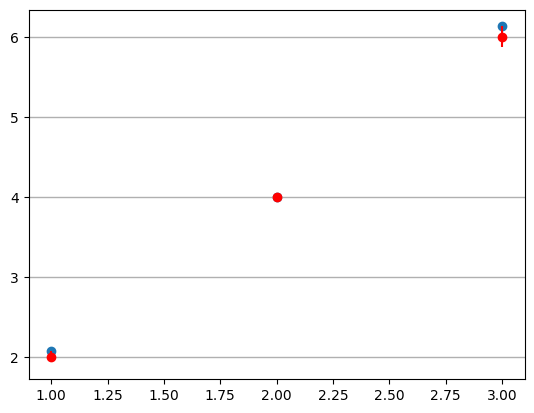

In [ ]:
nax = { 'x':[x9[3] , x9[6] , x9[10]] , 'y':[y9[3] , y9[6] , y9[10]] , 'sy': [sy9[3] , sy9[6] , sy9[10]]}

d = 0.030*8

n3 = [ Bragg(nax['x'][i]*np.pi/180 , d , l) for i in range( 0 , 3)]

print( n3 )
arr3 = [ [fun(i) , abs(fun(i)-i)] for i in n3]
print( arr3 )

plt.grid(visible= True , axis = 'y' , linewidth = 1)
plt.errorbar( [1 , 2 , 3] , [fun(i) for i in n3] , [abs(fun(i)-i)  for i in n3] , fmt = 'o', color = 'red')
plt.scatter( [1 , 2 , 3] , n3)
plt.show()

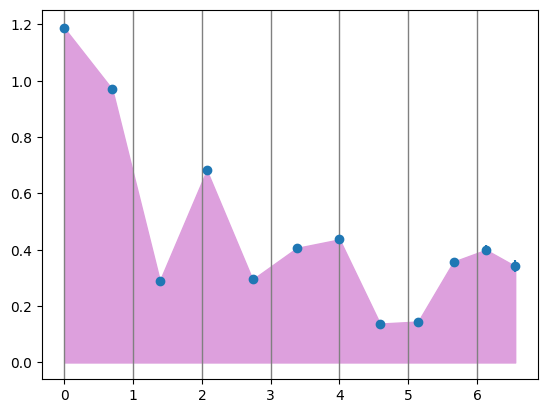

In [ ]:
#@title graph
epsilon3 = 0.3
d = 0.030*8
x91 = Bragg(x9*np.pi/180 , d , l)



plt.fill_between( x91 , y9 , color = 'plum')
plt.errorbar( x91 , y9 , sy9 , fmt = 'o')
plt.grid(visible= True , axis = 'x' , linewidth = 1 , color = 'grey')

plt.show()

In [ ]:
#@title data dist


n=17
xdist = np.array(data[n][data[n].columns[0]])
ydist = np.array(data[n][data[n].columns[1]])



ausy = [ydist[0]]


net = []

for i in range(1, len(xdist)):

  if xdist[i] == xdist[i-1]:
    ausy.append(ydist[i])

  else:

    avg = np.mean(ausy)
    std = np.std(ausy)

    if std == 0: std=1
    for iii in range( len(ausy)):
      net.append( (ausy[iii] - avg)/(std))
      continue
    ausy = [ydist[i]]

count , bin , p = plt.hist(net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) )
plt.clf()
cost = ExtendedBinnedNLL(count,bin,gauss_cdf)
u = Minuit( cost , scale = len(net) , mean=np.mean(net) , sigma = np.std( net))
u.fixed['scale'] = True
u.migrad()
u.hesse()


chi = 1-chi2.cdf(u.fval, df= u.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(u.fval/u.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.hist( net, bins=int(np.ceil( 1 + 3.322 * np.log(len(net)))) , density = True , label=chi_string)
plt.plot( np.linspace(min(bin) , max(bin)) , norm.pdf( np.linspace(min(bin) , max(bin)) , loc = u.values[1] , scale = u.values[2]))
plt.legend()

if show:
  print(round(np.mean(net),3) , round(np.std(net),3) , round(skew(net),3) , round(kurtosis(net),3))
  display(u)
else: plt.clf()

<Figure size 640x480 with 0 Axes>